# Лабораторная работа 1: Классификация изображений

## Import libs

In [1]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import pandas as pd
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop


## Get data

In [2]:
import os


In [3]:
cars_annos_train_df = pd.read_csv('cars_annos_train.csv')
cars_annos_test_df = pd.read_csv('cars_annos_test.csv')

cars_annos_train_df


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


In [4]:
class_counts = cars_annos_train_df['class'].value_counts()
class_counts


class
119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: count, Length: 196, dtype: int64

In [5]:
top_classes = cars_annos_train_df['class'].value_counts().head(5).index
filtered_train_df = cars_annos_train_df[cars_annos_train_df['class'].isin(top_classes)]
filtered_test_df = cars_annos_test_df[cars_annos_test_df['class'].isin(top_classes)]

class_mapping = {old_class: new_class for new_class, old_class in enumerate(top_classes)}

filtered_train_df.loc[:, 'class'] = filtered_train_df['class'].replace(class_mapping)
filtered_test_df.loc[:, 'class'] = filtered_test_df['class'].replace(class_mapping)

filtered_train_df


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
8,20,126,1269,771,3,00009.jpg
20,17,156,695,375,1,00021.jpg
42,22,39,588,362,0,00043.jpg
119,3,19,195,114,2,00120.jpg
122,151,568,1954,1271,4,00123.jpg
...,...,...,...,...,...,...
8024,1,20,140,82,0,08025.jpg
8046,226,481,1531,1126,1,08047.jpg
8055,62,98,583,416,0,08056.jpg
8106,95,174,1215,770,1,08107.jpg


In [6]:
filtered_class_counts = filtered_train_df['class'].value_counts()
filtered_class_counts


class
0    68
1    49
3    48
2    48
4    47
Name: count, dtype: int64

In [7]:
cars_annos_train_df = filtered_train_df.sample(260, random_state=42).reset_index(drop=True)
cars_annos_test_df = filtered_test_df.sample(256, random_state=42).reset_index(drop=True)


In [8]:
cars_annos_train_df['class'] = cars_annos_train_df['class'].astype('category')
cars_annos_test_df['class'] = cars_annos_test_df['class'].astype('category')


## Train test split

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [10]:
def plot_batch(images: torch.Tensor, labels: torch.Tensor):
    num_images = images.size(0)
    num_rows = int(np.ceil(np.sqrt(num_images)))

    fig, axs = plt.subplots(num_rows, num_rows)
    fig.subplots_adjust(hspace=0.1, wspace=1)

    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            image, label = images[i], str(int(labels[i]))
            image = image.numpy().transpose((1, 2, 0))
            image = (image * 0.5) + 0.5

            ax.imshow(image.squeeze())
            ax.set_title(int(label), fontsize=12)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.show()
    

In [49]:
class ImageDataset(Dataset):
    def __init__(self, image_dataframe, image_dir, transform=None):
        self.image_dataframe = image_dataframe
        self.transform = transform
        self.image_dataframe['im_path'] = self.image_dataframe['fname'].apply(lambda x: os.path.join(image_dir, x))

    def __len__(self):
        return len(self.image_dataframe)

    def __getitem__(self, idx):
        image_path = self.image_dataframe.loc[idx, 'im_path']
        label = self.image_dataframe.loc[idx, 'class']
            
        image = Image.open(image_path)

        if image.mode == 'L':
            image = image.convert('RGB')

        bbox_x1 = self.image_dataframe.loc[idx, 'bbox_x1']
        bbox_y1 = self.image_dataframe.loc[idx, 'bbox_y1']
        bbox_x2 = self.image_dataframe.loc[idx, 'bbox_x2']
        bbox_y2 = self.image_dataframe.loc[idx, 'bbox_y2']

        image = crop(image, top=bbox_y1, left=bbox_x1, height=bbox_y2-bbox_y1, width=bbox_x2-bbox_x1)

        if self.transform:
            image = self.transform(image)

        return image, label


In [50]:
torch.manual_seed(42)

# transform = transforms.Compose([
#   transforms.Resize((224, 224)),
#   transforms.ToTensor(),
#   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = ImageDataset(cars_annos_train_df, 'cars_train', transform=transform)
test_set = ImageDataset(cars_annos_test_df, 'cars_test', transform=transform)


In [51]:
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


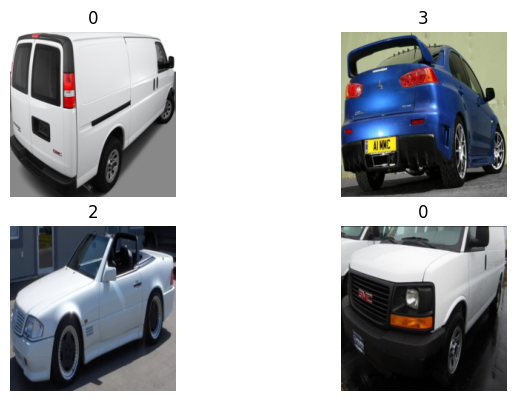

In [52]:
batch_images, batch_labels = next(iter(train_loader))
plot_batch(batch_images, batch_labels)


## ViT


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [54]:
patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 197       # Number of classes in the dataset
size = 224              # Size used for training = 224

epochs = 30             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)


In [55]:
num_classes = 5

In [56]:
epochs = 20

In [57]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)

        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        linear_projection += pos_embed

        return linear_projection
        

In [58]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        self.norm = nn.LayerNorm(self.latent_size)
        
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)          

        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        first_added_output = attention_output + embedded_patches

        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        return ff_output + first_added_output
        

In [59]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):

        enc_output = self.embedding(test_input)

        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        cls_token_embedding = enc_output[:, 0]

        return self.MLP_head(cls_token_embedding)
        

In [60]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

class AdaBound(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, weight_decay=weight_decay)
        super(AdaBound, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                lower_bound = group['lr'] * (1.0 - 1.0 / (group['gamma'] * state['step'] + 1))
                upper_bound = group['lr'] * (1.0 + 1.0 / (group['gamma'] * state['step']))

                lr = min(max(lower_bound, group['lr']), upper_bound)

                p.data.addcdiv_(-lr, exp_avg, torch.sqrt(exp_avg_sq) + group['weight_decay'] * p.data)

        return loss
        

## Training

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

def fine_tune(name, model, train_data_loader, valid_data_loader, writer, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', learning_rate=0.001):
    min_loss = np.inf
    
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adabound':
        optimizer = AdaBound(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.to(device)
    model.train()
    
    for ep in range(epochs):
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        epoch = ep + start_epoch

        for inputs, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{start_epoch + epochs}"):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # print('outputs', outputs)
            # print('labels', labels)
            
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        loss = running_loss / len(train_data_loader.dataset)
        
        valid_loss, f1, accuracy = calculate_metrics(model, valid_data_loader, device)

        if valid_loss < min_loss:
            print('Saving model...')
            min_loss = valid_loss

            torch.save(model.state_dict(), f'./checkpoints/{name}_{epoch}_{int(valid_loss)}.pt')

        writer.add_scalar("Training Loss", loss, epoch)
        writer.add_scalar("Validation Loss", valid_loss, epoch)
        writer.add_scalar("Validation F1 Score", f1, epoch)
        writer.add_scalar("Validation Accuracy", accuracy, epoch)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Validation loss: {valid_loss}, Min loss: {min_loss}, F1 Score: {f1}, Accuracy: {accuracy}')
    
    return model

def calculate_metrics(model, data_loader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    predictions = []
    labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, batch_labels in tqdm(data_loader):
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, batch_labels)
            
            total_loss += loss.item()
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    model.train()
    
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    f1 = f1_score(predictions, labels, average='macro')
    accuracy = torch.sum(predictions == labels).item() / len(labels)

    return total_loss, f1, accuracy


In [33]:
from torch.utils.tensorboard import SummaryWriter

def fine_tune_model_with_writer(name, model, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', learning_rate=0.001):
    writer = SummaryWriter(name)
    model = model.to(device)
    model = fine_tune(name, model, train_loader, test_loader, writer, start_epoch, epochs, device, optimizer, learning_rate)
    writer.flush()

    return model
    

## Results

In [40]:
from pathlib import Path
checkpoints = list(Path('./checkpoints/').glob('*.pt'))
checkpoints


[WindowsPath('checkpoints/custom_vit_adabound_0_2880.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_1_2688.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_2_2651.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_3_2646.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2724.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2729.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_5327.pt'),
 WindowsPath('checkpoints/custom_vit_adam_1_2695.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2649.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2674.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_5291.pt'),
 WindowsPath('checkpoints/custom_vit_adam_3_2658.pt'),
 WindowsPath('checkpoints/custom_vit_adam_4_2652.pt'),
 WindowsPath('checkpoints/vit_adabound_0_119.pt'),
 WindowsPath('checkpoints/vit_adabound_0_132.pt'),
 WindowsPath('checkpoints/vit_adabound_0_133.pt'),
 WindowsPath('checkpoints/vit_adabound_0_141.pt'),
 WindowsPath('checkpoints/vit_adabound_0_2594.pt'),
 WindowsPath(

In [41]:
def print_results(name, model, test_loader, scaler=None):
    total_loss, f1, accuracy = calculate_metrics(model, test_loader, device='cuda')
    print(f'loss: {total_loss}')
    print(f'f1: {f1}')
    print(f'accuracy: {accuracy}\n')


### Before hyperparams tuning, 5 classes

In [63]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


In [67]:
model.load_state_dict(torch.load('checkpoints/vit_adabound_32_104.pt'))
print_results("vit_adabound", model, test_loader)


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.74it/s]

loss: 104.04416334629059
f1: 0.1889316897791474
accuracy: 0.25



### After hyperparams tuning, 5 classes

In [70]:
model1 = VitTransformer(num_encoders1, latent_size1, device, num_classes).to(device)


In [72]:
model1.load_state_dict(torch.load('checkpoints/vit_adabound_upd__36_100.pt'))
print_results("vit_adabound", model1, test_loader)


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 21.46it/s]

loss: 100.25712192058563
f1: 0.19013280571330315
accuracy: 0.32421875

